<a href="https://colab.research.google.com/github/Ihoroderii/colab/blob/main/BTC_yfinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance mplfinance

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ticker                          BTC-USD
Datetime                               
2024-03-08 00:00:00+00:00  66866.164062
2024-03-08 01:00:00+00:00  66957.359375
2024-03-08 02:00:00+00:00  66932.921875
2024-03-08 03:00:00+00:00  67060.664062
2024-03-08 04:00:00+00:00  67071.132812
...                                 ...
2024-09-07 19:00:00+00:00  54241.472656
2024-09-07 20:00:00+00:00  54175.871094
2024-09-07 21:00:00+00:00  53904.566406
2024-09-07 22:00:00+00:00  53875.113281
2024-09-07 23:00:00+00:00  53829.402344

[4416 rows x 1 columns]
dot index 2024-03-19 00:00:00 = 61536.1796875  → SMA_10_belove: 62662.27437041334
First price above 62662.27437041334 after 2024-03-19 00:00:00+00:00: [68074.2734375] at 2024-03-19 00:00:00+00:00
dot index 2024-03-20 00:00:00 = 60807.78515625  → SMA_10_belove: 62145.709046599746
First price above 62145.709046599746 after 2024-03-20 00:00:00+00:00: [63337.12109375] at 2024-03-20 00:00:00+00:00
dot index 2024-04-13 00:00:00 = 60919.10546875  → SMA_10_be

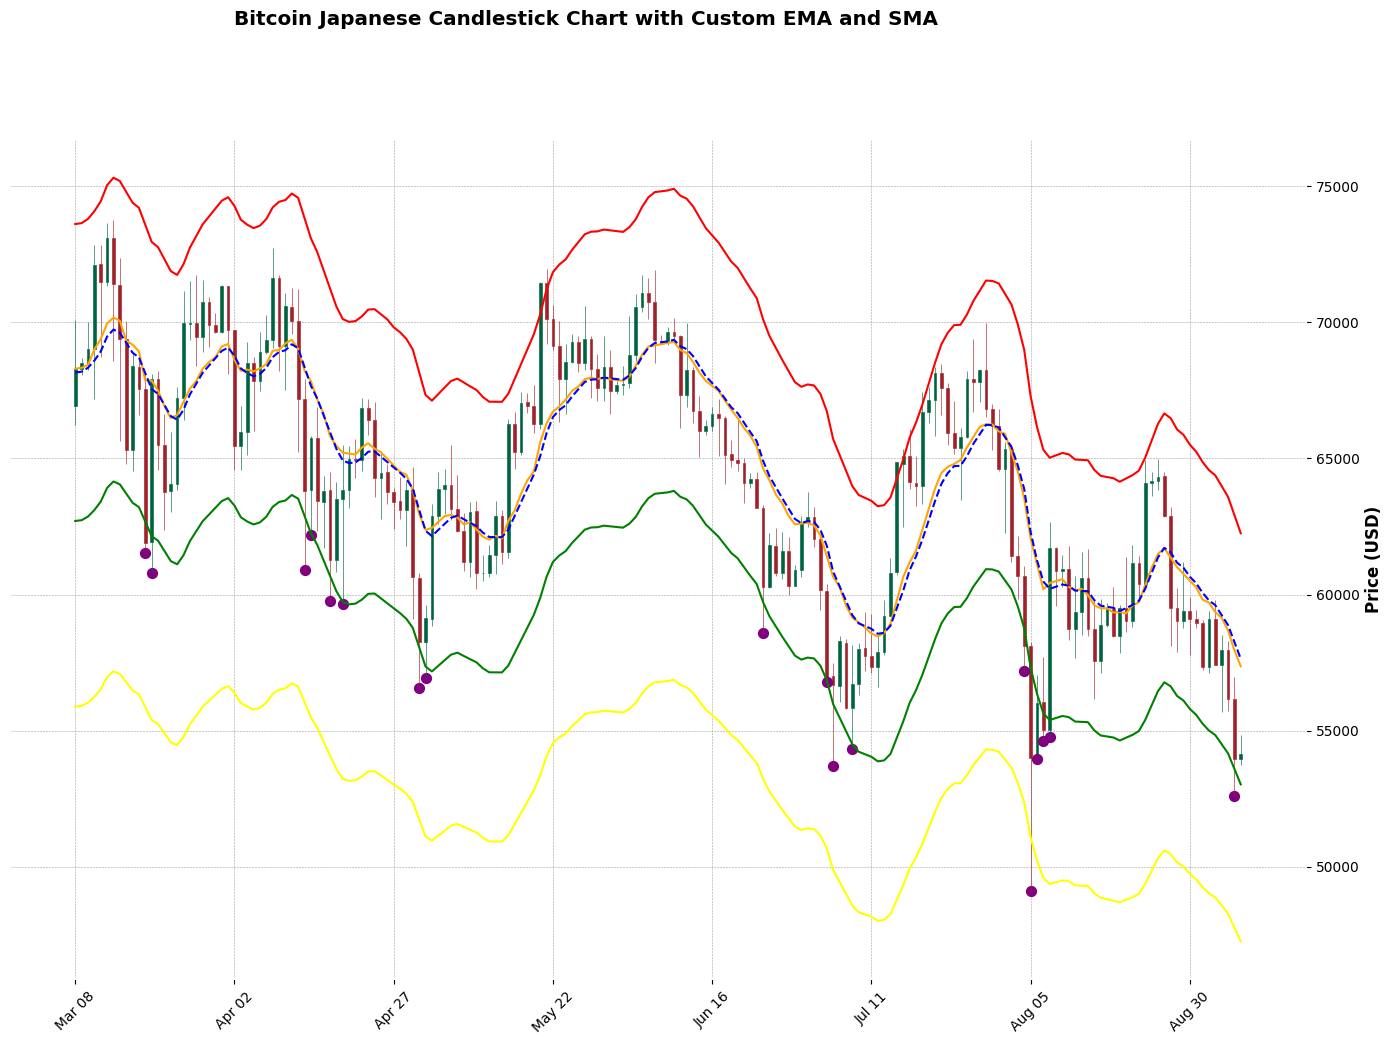

In [48]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf  # Candlestick chart library

# Load Bitcoin price data
btc = yf.download("BTC-USD", start="2024-03-08", end="2024-09-08", interval="1d")
btc_hour = yf.download("BTC-USD", start="2024-03-08", end="2024-09-08", interval="1h")

print(btc_hour['Low'])

# Flatten the MultiIndex columns
btc.columns = btc.columns.droplevel(1)

# Print DataFrame columns to check structure
#print("Columns in DataFrame:", btc.columns)

# If DataFrame is empty, raise an error
if btc.empty:
    raise ValueError("Error: No data downloaded. Check API or date range.")

# Ensure required columns exist
required_columns = ['Open', 'High', 'Low', 'Close']
for col in required_columns:
    if col not in btc.columns:
        raise KeyError(f"Missing column: {col}")

# Fix NaN values (if any)
btc.dropna(subset=required_columns, inplace=True)

# Calculate Moving Averages
btc['Middle'] = (btc['High'] + btc['Low'])/2

btc['EMA_10'] = btc['Middle'].ewm(span=12, adjust=False).mean()  # 10-period EMA
btc['EMA_10_close'] = btc['Close'].ewm(span=12, adjust=False).mean()
btc['SMA_10_above'] = btc['EMA_10'] * 1.08  # 8% above EMA
btc['SMA_10_belove'] = btc['EMA_10'] * 0.92  # 8% below EMA
btc['SMA_10_belove_1'] = btc['EMA_10'] * 0.82  # 18% below EMA



# Find points where price is below `SMA_10_belove`
btc['Dot_Signal'] = btc['Low'].where(btc['Low'] < btc['SMA_10_belove'])  # NaN where condition is false

for index, row in btc.iterrows():
  if pd.notna(row['Dot_Signal']):
    target_price = btc.loc[index, 'SMA_10_belove']
    print(f"dot index {index} = {row['Dot_Signal']}  → SMA_10_belove: {target_price}")
    # Define the starting index and target price
    #start_index = '2024-06-01 12:00:00'  # Example index
    #target_price = 50000  # Example price

    start_index = pd.to_datetime(index).tz_localize("UTC")
    # Filter only rows AFTER the given index
    filtered_data = btc_hour.loc[start_index:].copy()  # Get all rows after start_index

    # Find the first price that is greater than target_price
    higher_price_row = filtered_data[filtered_data['High'] > target_price].head(1)

    # Display result
    if not higher_price_row.empty:
        next_index = higher_price_row.index[0]
        next_price = higher_price_row['High'].values[0]
        print(f"First price above {target_price} after {start_index}: {next_price} at {next_index}")
    else:
        print(f"No price found above {target_price} after {start_index}")

# Calculate the percentage of time the price was below SMA_10_belove
price_below_sma_10_b = btc[btc['Low'] < btc['SMA_10_belove']]
#print(price_below_sma_10_b)
percentage_below_sma_10_b = (len(price_below_sma_10_b) / len(btc)) * 100

print(f"Percentage of time Bitcoin price was below SMA_10_belove: {percentage_below_sma_10_b:.2f}%")

# Define custom moving average plots
ema_10 = mpf.make_addplot(btc['EMA_10'], color='blue', linestyle='--', width=1.5)
sma_50 = mpf.make_addplot(btc['SMA_10_above'], color='red', linestyle='-', width=1.5)
sma_10_b = mpf.make_addplot(btc['SMA_10_belove'], color='green', linestyle='-', width=1.5)
sma_10_b_1 = mpf.make_addplot(btc['SMA_10_belove_1'], color='yellow', linestyle='-', width=1.5)
ema_10_close = mpf.make_addplot(btc['EMA_10_close'], color='orange', linestyle='-', width=1.5)


#  Add dots where price is below `SMA_10_belove`
dot_markers = mpf.make_addplot(
    btc['Dot_Signal'],
    type='scatter',  # Scatter plot type for individual dots
    marker='o',
    markersize=50,  # Adjust size for visibility
    color='purple'
)

# Plot with custom moving averages
mpf.plot(
    btc,
    type="candle",
    style="charles",
    volume=False,
    title="Bitcoin Japanese Candlestick Chart with Custom EMA and SMA",
    ylabel="Price (USD)",
    addplot=[ema_10_close, ema_10, sma_50, sma_10_b, sma_10_b_1, dot_markers],  # Add custom moving averages
    figsize=(18, 12)
)

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf  # Candlestick chart library

# Load Bitcoin price data
btc = yf.download("BTC-USD", start="2024-11-08", end="2025-02-08", interval="1d")

btc_one_hour = yf.download("BTC-USD", start="2024-11-08", end="2025-02-08", interval="1h")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Columns in DataFrame: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
First item :  82669.11468750001
Index: 2024-11-08 00:00:00, SMA_10_above: 82669.11468750001
Index: 2024-11-09 00:00:00, SMA_10_above: 82707.89343750001
Index: 2024-11-10 00:00:00, SMA_10_above: 83354.69790865385
Index: 2024-11-11 00:00:00, SMA_10_above: 85268.99101886096
Index: 2024-11-12 00:00:00, SMA_10_above: 86764.88124672852
Index: 2024-11-13 00:00:00, SMA_10_above: 88467.34523761644
Index: 2024-11-14 00:00:00, SMA_10_above: 89353.97890298314
Index: 2024-11-15 00:00:00, SMA_10_above: 90738.18036983188
Index: 2024-11-16 00:00:00, SMA_10_above: 91825.09949562697
Index: 2024-11-17 00:00:00, SMA_10_above: 92626.3949097613
Index: 2024-11-18 00:00:00, SMA_10_above: 93420.18828902877
Index: 2024-11-19 00:00:00, SMA_10_above: 94391.12735033204
Index: 2024-11-20 00:00:00, SMA_10_above: 95544.28492143481
Index: 2024-11-21 00:00:00, SMA_10_above: 97212.10334698329
Index: 2024-11-22 00:00:00,

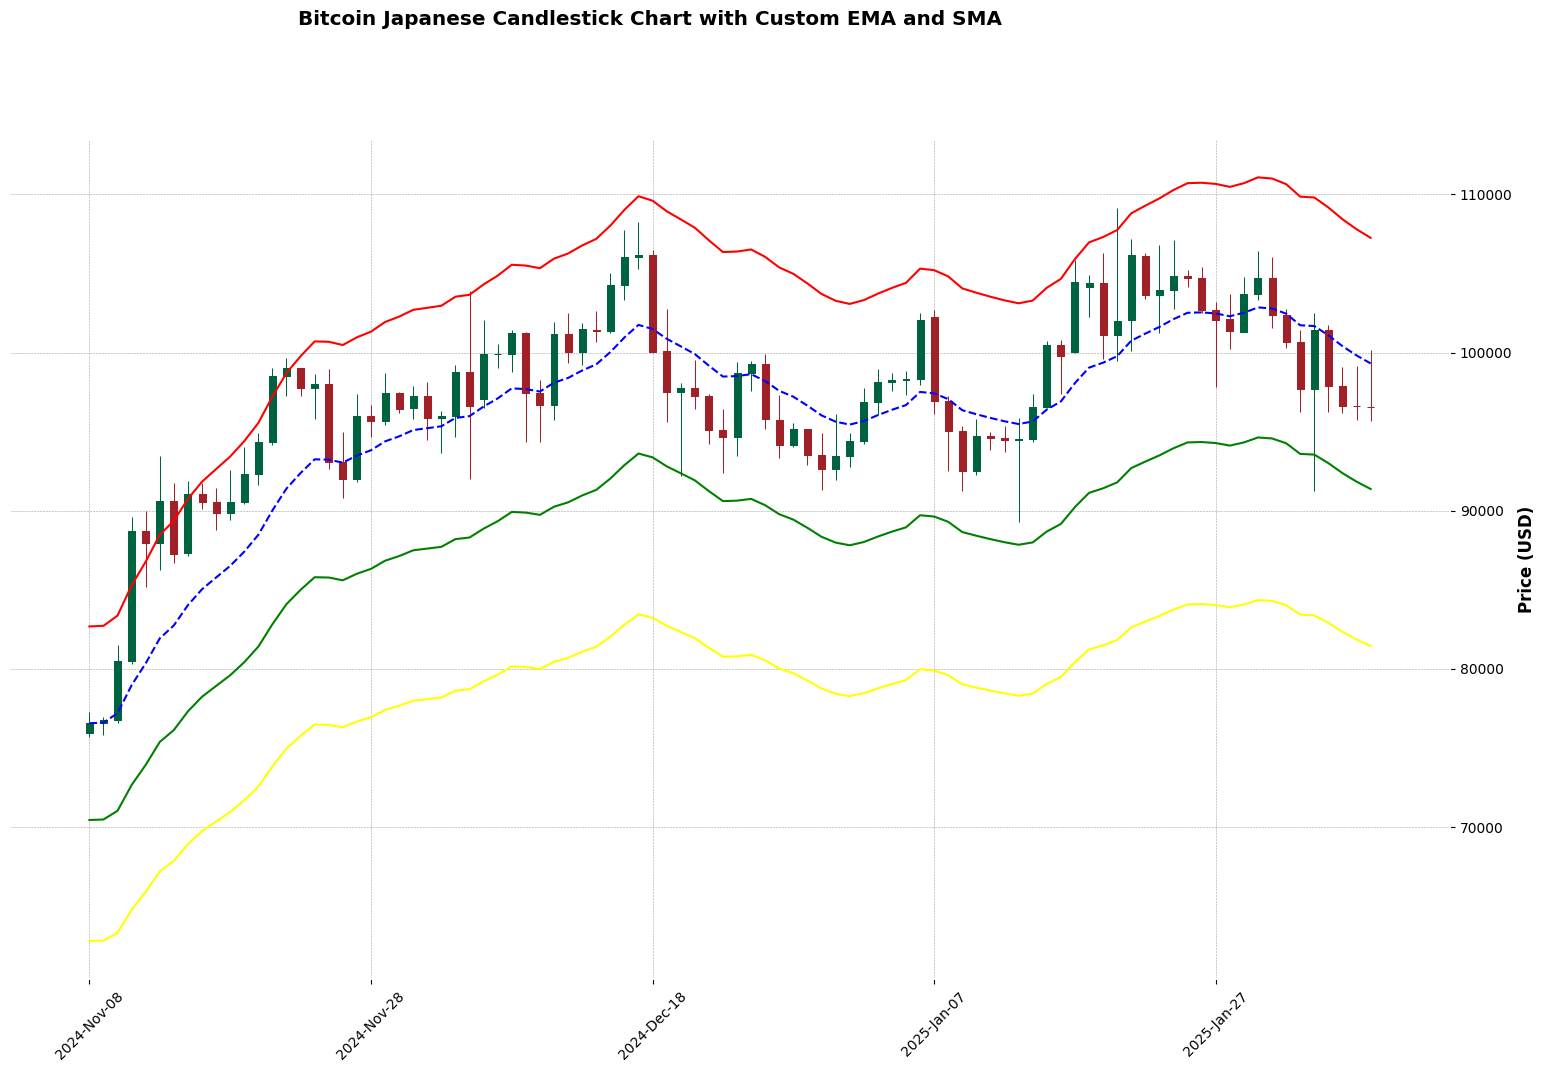

In [ ]:
# Flatten the MultiIndex columns
btc.columns = btc.columns.droplevel(1)

# Print DataFrame columns to check structure
print("Columns in DataFrame:", btc.columns)

# If DataFrame is empty, raise an error
if btc.empty:
    raise ValueError("Error: No data downloaded. Check API or date range.")

# Ensure required columns exist
required_columns = ['Open', 'High', 'Low', 'Close']
for col in required_columns:
    if col not in btc.columns:
        raise KeyError(f"Missing column: {col}")

# Fix NaN values (if any)
btc.dropna(subset=required_columns, inplace=True)

# Calculate Moving Averages
btc['EMA_10'] = btc['Close'].ewm(span=12, adjust=False).mean()  # 10-period EMA
btc['SMA_10_above'] = btc['EMA_10'] * 1.08  # 8% above EMA
btc['SMA_10_belove'] = btc['EMA_10'] * 0.92  # 8% below EMA
btc['SMA_10_belove_1'] = btc['EMA_10'] * 0.82  # 18% below EMA

print("First item : ", btc['SMA_10_above'].values[0])

for index, row in btc.iterrows():
   print(f"Index: {index}, SMA_10_above: {row['SMA_10_above']}")


# Calculate the percentage of time the price was below SMA_10_belove
price_below_sma_10_b = btc[btc['Low'] < btc['SMA_10_belove']]
print(price_below_sma_10_b)
percentage_below_sma_10_b = (len(price_below_sma_10_b) / len(btc)) * 100

print(f"Percentage of time Bitcoin price was below SMA_10_belove: {percentage_below_sma_10_b:.2f}%")

# Define custom moving average plots
ema_10 = mpf.make_addplot(btc['EMA_10'], color='blue', linestyle='--', width=1.5)
sma_50 = mpf.make_addplot(btc['SMA_10_above'], color='red', linestyle='-', width=1.5)
sma_10_b = mpf.make_addplot(btc['SMA_10_belove'], color='green', linestyle='-', width=1.5)
sma_10_b_1 = mpf.make_addplot(btc['SMA_10_belove_1'], color='yellow', linestyle='-', width=1.5)

# Plot with custom moving averages
mpf.plot(
    btc,
    type="candle",
    style="charles",
    volume=False,
    title="Bitcoin Japanese Candlestick Chart with Custom EMA and SMA",
    ylabel="Price (USD)",
    addplot=[ema_10, sma_50, sma_10_b, sma_10_b_1],  # Add custom moving averages
    figsize=(20, 12)
)